In [11]:
%load_ext autoreload
%autoreload 2

import re

import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Columns statistics

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
train_df[['text']].describe()

,text
count,7613
unique,7503
top,11-Year-Old Boy Charged With Manslaughter of T...
freq,10


## Preprocessing

In [15]:
# TODO to consider
# stopwords removal
# punctuation removal
# tokenization verification

EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

train_df[:3]

,id,keyword,location,text,target,text_preproc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...


In [16]:
def _count(txt: str) -> int:
    return len(txt.split(' '))

train_df['text_length'] = train_df['text'].apply(_count)

train_df[:3]

,id,keyword,location,text,target,text_preproc,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,22


In [17]:
train_positive = train_df.loc[train_df['target'] == 1]
train_negative = train_df.loc[train_df['target'] == 0]

len(train_positive), len(train_negative)

(3271, 4342)

In [18]:
def _count_occurrences(data:str, field: str) -> str:
    results = {}
    for t in data.itertuples():
        l = getattr(t, field)
        if t.text_length in results:
            results[l] += 1
        else:
            results[l] = 0
    return results

positive_lengths = _count_occurrences(train_positive, 'text_length')
negative_lengths = _count_occurrences(train_negative, 'text_length')

Text(0.5, 0.98, 'Text lengths')

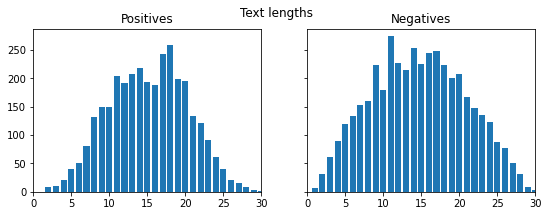

In [19]:
positive_names = list(positive_lengths.keys())
positive_values = list(positive_lengths.values())

negative_names = list(negative_lengths.keys())
negative_values = list(negative_lengths.values())

fig , axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].set_title('Positives')
axs[0].set_xlim([0, 30])
axs[0].bar(positive_names, positive_values)
axs[1].set_title('Negatives')
axs[1].set_xlim([0, 30])
axs[1].bar(negative_names, negative_values)
fig.suptitle('Text lengths')

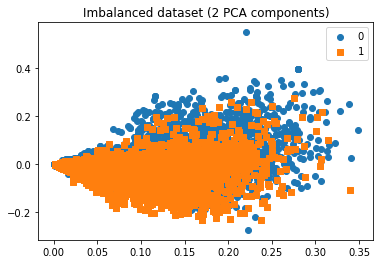

In [32]:
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

X = train_df['text_preproc']
y = train_df['target']

vec = TfidfVectorizer(min_df=4, max_df=0.3)
vec.fit(X)
X_vec = vec.transform(X)

sgd = TruncatedSVD (n_components=2)
X = sgd.fit_transform(X_vec)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')